In [1]:
%matplotlib inline
import numpy as np
import os
import time
import h5py
import keras
import pandas as pd
import math
import joblib
import json
import matplotlib.pyplot as plt

from IPython.display import display

from fuel.datasets.hdf5 import H5PYDataset

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from keras.layers import (Input, Dense, Lambda, Flatten, Reshape, BatchNormalization, 
                          Activation, Dropout, Conv2D, Conv2DTranspose,
                          Concatenate, Add, Multiply)
from keras.engine import InputSpec
from keras.losses import sparse_categorical_crossentropy
from keras.optimizers import RMSprop, Adam, SGD
from keras.models import Model
from keras.utils import to_categorical
from keras.regularizers import l2
from keras import metrics
from keras import backend as K
from keras_tqdm import TQDMNotebookCallback

import tensorflow as tf

/home/brian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Parameters

In [2]:
img_rows, img_cols, img_chns = 20, 20, 3
#img_rows, img_cols, img_chns = 32, 32, 3
original_img_size = (img_rows, img_cols, img_chns)
pixel_level_divisor = 16
sample = 16

batch_size = int(os.environ.get('BATCH_SIZE', 1))
epochs = int(os.environ.get('EPOCHS', 1000))
activation = os.environ.get('ACTIVATION', 'relu')
decay = float(os.environ.get('DECAY', 0.0))
learning_rate = float(os.environ.get('LEARNING_RATE', 0.001))
resnet_depth = int(os.environ.get('RESNET_DEPTH', 15))

# Load CIFAR10 dataset

In [3]:
assert img_rows % 2 == 0
assert img_cols % 2 == 0
crop = (32 - img_rows) // 2

ftrain = H5PYDataset("../../data/cifar10/cifar10.hdf5", which_sets=('train',))
X_train, y_train = ftrain.get_data(ftrain.open(), slice(0, ftrain.num_examples))
X_train = np.moveaxis(X_train[:], 1, 3)
X_train = X_train[:sample, crop:-crop, crop:-crop, :]
#X_train_out = X_train.copy().reshape((X_train.shape[0], -1)) 
X_train_out = []
for i in range(img_rows):
    for j in range(img_cols):
        for k in range(img_chns):
            X_train_out.append((X_train[:, i, j, k] // pixel_level_divisor).copy())
# X_train_out = X_train.copy().reshape((X_train.shape[0], -1)) 
#.reshape((X_train.shape[0], -1, 1))
X_train = X_train / 255.

ftest = H5PYDataset("../../data/cifar10/cifar10.hdf5", which_sets=('test',))
X_test, y_test = ftest.get_data(ftest.open(), slice(0, ftest.num_examples))
X_test = np.moveaxis(X_test[:], 1, 3)
X_test = X_test[:, :img_rows, :img_cols, :]
X_test_out = []
for i in range(img_rows):
    for j in range(img_cols):
        for k in range(img_chns):
            X_test_out.append((X_test[:, i, j, k] // pixel_level_divisor).copy())
#X_test_out = X_test.copy().reshape((X_test.shape[0], -1))
#.reshape((X_test.shape[0], -1, 1))
X_test = X_test / 255.

print(X_train.shape, y_train.shape)
print(len(X_train_out))
print(X_train_out[0].shape)
print(X_test.shape, y_test.shape)
print(len(X_test_out))
print(X_test_out[0].shape)

(16, 20, 20, 3) (50000, 1)
1200
(16,)
(10000, 20, 20, 3) (10000, 1)
1200
(10000,)


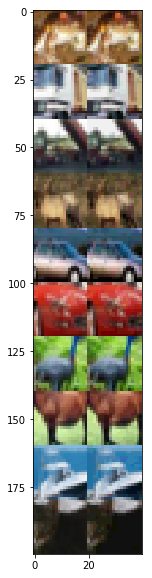

In [4]:
#figure = np.zeros((img_rows * n, img_cols * n * 2, img_chns))
#
#for i in range(n // 2):
#    for j in range(n * 2):
#        orig_img = X_train[i * 2 * n + j] 
#        d_x = (2 * i) * img_rows 
#        d_y = j * img_cols
#        figure[d_x:d_x + img_rows, d_y:d_y + img_cols] = orig_img
#        
#        # Digitize
#        img = ((orig_img * 255. // pixel_level_divisor) * pixel_level_divisor).astype(float) / 255
#        figure[d_x + img_rows:d_x + 2 * img_rows, d_y:d_y + img_cols] = img
#        #print(img)

n = min(sample, 10)
figure = np.zeros((img_rows * n, img_cols * 2, img_chns))
for i in range(n):
    orig_img = X_train[i] 
    dy = img_rows * i
    figure[dy:dy + img_rows, :img_cols] = orig_img
    
    # Digitize
    img = ((orig_img * 255. // pixel_level_divisor) * pixel_level_divisor).astype(float) / 255
    figure[dy:dy + img_rows, img_cols:2 * img_cols] = img

plt.figure(figsize=(n * 4, 10))
plt.imshow(figure)
plt.show()

# Pixel CNN Helpers

In [5]:
class PixelConv2D(Conv2D):
    def __init__(self, ptype, *args, **kwargs):
        # ptype corresponds to pixel type and mask type, e.g. ra, ga, ba, rb, gb, bb
        assert ptype[0] in ['r', 'g', 'b'], ptype
        assert ptype[1] in ['a', 'b'], ptype
        self.ptype = ptype
        super(PixelConv2D, self).__init__(*args, **kwargs)
       
    def build_mask(self, kernel_shape):
        # kernel_shape = kern_dim x kern_dim x total_filters
        #              = kern_dim x kern_dim x r_g_b_filters x filters_per_channel
        assert kernel_shape[0] == kernel_shape[1], "{} must be equal in first two dims".format(kernel_shape)
        assert kernel_shape[0] % 2 == 1, "{} must be odd size in first two dims".format(kernel_shape)
        assert kernel_shape[2] % 3 == 0, "{} must be divisible by 3".format(kernel_shape)
        data = np.ones(kernel_shape)
        
        data.shape
        mid = data.shape[0] // 2
        if self.ptype[0] == 'r':
            filt_prev = 0
            filt_thres = int(data.shape[2] / 3)
        elif self.ptype[0] == 'g':
            filt_prev = int(data.shape[2] / 3)
            filt_thres = int(2 * data.shape[2] / 3)
        else:
            assert self.ptype[0] == 'b', self.ptype
            filt_prev = int(2 * data.shape[2] / 3)
            filt_thres = data.shape[2]
            
        # print(data.shape, self.ptype, mid, filt_prev, filt_thres)
        
        for k1 in range(data.shape[0]):
            for k2 in range(data.shape[1]):
                for chan in range(data.shape[2]):
                    #for filt in range(data.shape[3]):
                    if (self.ptype[1] == 'a' and filt_prev <= chan < filt_thres and k1 == mid and k2 == mid):
                        data[k1, k2, chan, :] = 0
                        #if k1 > mid or (k1 >= mid and k2 >= mid) or chan >= filt_thres:
                    elif k1 > mid or (k1 >= mid and k2 > mid) or chan >= filt_thres:
                        data[k1, k2, chan, :] = 0
            
        return K.constant(np.ravel(data), dtype='float32', shape=kernel_shape)
       
    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (input_dim, self.filters)
        
        self.kernel_mask = self.build_mask(kernel_shape)
        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        # Set input spec.
        self.input_spec = InputSpec(ndim=self.rank + 2,
                                    axes={channel_axis: input_dim})
        self.built = True

    def call(self, inputs):
        masked_kernel = self.kernel * self.kernel_mask
        outputs = K.conv2d(
            inputs,
            masked_kernel,
            strides=self.strides,
            padding=self.padding,
            data_format=self.data_format,
            dilation_rate=self.dilation_rate)

        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        
        return outputs

# Model

In [6]:
if K.image_data_format() == 'channels_last':
    bn_axis = 3
else:
    bn_axis = 1
    
def conv_block(input_tensor, filters, kernel_size, name, is_first=False):
    outs = []
    for t in ['rb', 'gb', 'bb']:
        if is_first:
            t = t[0] + 'a'
        x = PixelConv2D(t, filters, kernel_size, name='res' + name + t, padding='same')(input_tensor)
        # x = BatchNormalization(axis=bn_axis, name='bn' + name + t)(x)
        x = Activation('relu')(x)
        outs.append(x)
        
    return Concatenate()(outs)

def resnet_block(input_tensor, filters, stage, block):
    name_base = str(stage) + block + '_branch'
    filters1, filters2, filters3 = filters
    x = input_tensor
    x = conv_block(x, filters1, (1, 1), name=name_base + '2a')
    x = conv_block(x, filters2, (3, 3), name=name_base + '2b')
    x = conv_block(x, filters3, (1, 1), name=name_base + '2c')
    x = Add()([x, input_tensor])
    
    return x

def final_block(input_tensor, filters, in_filters, name, kernel_size=(1, 1)):
    outs = []
    channel_name = 'rgb'
    for channel in range(img_chns):
        x = Lambda(lambda x: x[:, :, :, channel * in_filters:(channel + 1) * in_filters])(input_tensor)
        x = Conv2D(filters, kernel_size, name='final' + name + channel_name[channel], padding='same')(x)
        # x = BatchNormalization(axis=bn_axis, name='bn' + name + t)(x)
        x = Activation('relu')(x)
        outs.append(x)
        
    return Concatenate()(outs)

def build_outputs(input_tensor, final_filters):
    outputs = []
    for k1 in range(img_rows):
        for k2 in range(img_cols):
            for channel in range(img_chns):
                out = Lambda(lambda x: x[:, k1, k2, channel * final_filters:(channel + 1) * final_filters])(input_tensor)
                out = Dense(256 // pixel_level_divisor, kernel_regularizer=l2(0.001),  bias_regularizer=l2(0.001))(out)
                #out = Dense(256 // pixel_level_divisor)(out)
                outputs.append(out)
                
    return outputs

In [7]:
def pixelcnn_loss(target, output):
    # return sparse_categorical_crossentropy(target, output)
    # Note: tf.nn.sparse_softmax_cross_entropy_with_logits
    # expects logits, Keras expects probabilities.
    # _epsilon = tf.convert_to_tensor(K.epsilon(), output.dtype.base_dtype)
    # output = tf.clip_by_value(output, _epsilon, 1 - _epsilon)
    # output = tf.log(output)
    
    # print(target.shape, output.shape)
    # output_shape = output.get_shape()
    targets = tf.cast(target, 'int64')
    targets = tf.reshape(targets, (-1,))
    # logits = tf.reshape(output, [-1, int(output_shape[-1])])
    res = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=targets, logits=output)
    
    return tf.reduce_mean(res)

#def data_generator(X_data, X_data_out, batch_size):
#    while True:
#        index = np.arange(len(X_data))
#        np.random.shuffle(index)
#        for i in range(len(X_data) // batch_size):
#            batch_in_data = X_data[index[i * batch_size: (i+1)*batch_size], :, :, :]
#            batch_out_data = X_data_out[index[i * batch_size: (i+1)*batch_size], :, :]
#            yield batch_in_data, to_categorical(batch_out_data, num_classes=256).reshape(batch_size, -1)
#            
#for x, y in data_generator(X_test, X_test_out, 1):
#    print(x.shape, y.shape)
#    break

In [8]:
print("Building conv layers...")
main_input = Input(shape=original_img_size, name='main_input')

x = conv_block(main_input, 256, (7, 7), name='conv1', is_first=True)

for stage in range(resnet_depth):
    x = resnet_block(x, [128, 128, 256], stage, 'a')

x = final_block(x, 1000, 256, '1x1_1000_1')
x = final_block(x, 1000, 1000, '1x1_1000_2')

print("Building output layers...")
outputs = build_outputs(x, 1000)

#main_output = Concatenate()(outputs)
#main_output = Reshape(original_img_size + (256,))(main_output)
main_output = outputs

print("Building model...")
model = Model(inputs=main_input, outputs=main_output)
optimizer = RMSprop(lr=learning_rate)
model.compile(optimizer=optimizer, loss=pixelcnn_loss)
model.summary()

Building conv layers...
Building output layers...
Building model...
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
main_input (InputLayer)          (None, 20, 20, 3)     0                                            
____________________________________________________________________________________________________
resconv1ra (PixelConv2D)         (None, 20, 20, 256)   37888       main_input[0][0]                 
____________________________________________________________________________________________________
resconv1ga (PixelConv2D)         (None, 20, 20, 256)   37888       main_input[0][0]                 
____________________________________________________________________________________________________
resconv1ba (PixelConv2D)         (None, 20, 20, 256)   37888       main_input[0][0]                 
_______________________

lambda_557 (Lambda)              (None, 1000)          0           concatenate_48[0][0]             
____________________________________________________________________________________________________
lambda_558 (Lambda)              (None, 1000)          0           concatenate_48[0][0]             
____________________________________________________________________________________________________
lambda_559 (Lambda)              (None, 1000)          0           concatenate_48[0][0]             
____________________________________________________________________________________________________
lambda_560 (Lambda)              (None, 1000)          0           concatenate_48[0][0]             
____________________________________________________________________________________________________
lambda_561 (Lambda)              (None, 1000)          0           concatenate_48[0][0]             
___________________________________________________________________________________________

dense_233 (Dense)                (None, 16)            16016       lambda_239[0][0]                 
____________________________________________________________________________________________________
dense_234 (Dense)                (None, 16)            16016       lambda_240[0][0]                 
____________________________________________________________________________________________________
dense_235 (Dense)                (None, 16)            16016       lambda_241[0][0]                 
____________________________________________________________________________________________________
dense_236 (Dense)                (None, 16)            16016       lambda_242[0][0]                 
____________________________________________________________________________________________________
dense_237 (Dense)                (None, 16)            16016       lambda_243[0][0]                 
___________________________________________________________________________________________

____________________________________________________________________________________________________
dense_1101 (Dense)               (None, 16)            16016       lambda_1107[0][0]                
____________________________________________________________________________________________________
dense_1102 (Dense)               (None, 16)            16016       lambda_1108[0][0]                
____________________________________________________________________________________________________
dense_1103 (Dense)               (None, 16)            16016       lambda_1109[0][0]                
____________________________________________________________________________________________________
dense_1104 (Dense)               (None, 16)            16016       lambda_1110[0][0]                
____________________________________________________________________________________________________
dense_1105 (Dense)               (None, 16)            16016       lambda_1111[0][0]       

In [9]:
start = time.time()

early_stopping = keras.callbacks.EarlyStopping('loss', min_delta=1.0, patience=30)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=15, min_lr=0.01 * learning_rate)
#early_stopping = keras.callbacks.EarlyStopping('val_loss', min_delta=0.1, patience=10)
#reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.001 * learning_rate)

#history = model.fit_generator(
#    data_generator(X_train, X_train_out, batch_size),
#    #batch_size=batch_size,
#    epochs=epochs,
#    steps_per_epoch=len(X_train) // batch_size,
#    callbacks=[TQDMNotebookCallback(), early_stopping, reduce_lr],
#    validation_data=data_generator(X_test, X_test_out, batch_size),
#    validation_steps=len(X_test) // batch_size,
#    max_queue_size=32,
#    #verbose=2
#)


class MyTQDMNotebookCallback(TQDMNotebookCallback):
    def format_metrics(self, logs):
        metrics = self.params['metrics']
        strings = []
        for i, metric in enumerate(metrics):
            if metric in logs:
                strings.append(self.metric_format.format(name=metric, value=np.mean(logs[metric], axis=None)))
                if i > 3:
                    break
        return self.separator.join(strings)

history = model.fit(
    X_train, X_train_out,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[MyTQDMNotebookCallback(), early_stopping, reduce_lr],
    #validation_data=(X_test, X_test_out),
    verbose=0
)


done = time.time()
elapsed = done - start
print("Elapsed: ", elapsed)


Elapsed:  7011.193255901337


,loss,dense_1_loss,dense_2_loss,dense_3_loss,dense_4_loss,dense_5_loss,dense_6_loss,dense_7_loss,dense_8_loss,dense_9_loss,...,dense_1192_loss,dense_1193_loss,dense_1194_loss,dense_1195_loss,dense_1196_loss,dense_1197_loss,dense_1198_loss,dense_1199_loss,dense_1200_loss,lr
count,343.000000,343.000000,343.000000,343.000000,343.000000,343.000000,343.000000,343.000000,343.000000,343.000000,...,343.000000,343.000000,343.000000,343.000000,343.000000,343.000000,343.000000,343.000000,343.000000,343.000000
mean,463.339056,2.485560,1.271341,0.804821,1.058738,0.680861,0.558377,0.565095,0.457265,0.354917,...,0.449382,0.340115,0.303238,0.391914,0.340932,0.316130,0.384748,0.371283,0.250860,0.000784
std,732.189634,0.083329,0.522598,0.769280,0.543963,0.608882,0.666268,0.620645,0.596977,0.625036,...,0.637295,0.620923,0.597165,0.672855,0.625233,0.626596,0.610613,0.626626,0.538044,0.000248
min,6.798529,2.357752,0.514913,0.001718,0.366055,0.004527,0.000636,0.005169,0.000198,0.000050,...,0.000064,0.000013,0.000006,0.000070,0.000018,0.000003,0.000043,0.000013,0.000003,0.000500
0%,6.798529,2.357752,0.514913,0.001718,0.366055,0.004527,0.000636,0.005169,0.000198,0.000050,...,0.000064,0.000013,0.000006,0.000070,0.000018,0.000003,0.000043,0.000013,0.000003,0.000500
25%,19.648740,2.417423,0.862896,0.096572,0.643702,0.151928,0.040581,0.071772,0.003446,0.000623,...,0.001046,0.000254,0.000176,0.000746,0.000311,0.000150,0.000670,0.000267,0.000107,0.000500
50%,82.261401,2.459973,1.209749,0.638526,0.944500,0.548143,0.291484,0.329550,0.170768,0.025343,...,0.069258,0.009878,0.004587,0.012457,0.005255,0.003425,0.028848,0.007094,0.001755,0.001000
75%,559.100126,2.550683,1.510947,1.322824,1.301533,1.025272,0.805744,0.887406,0.746163,0.396402,...,0.767366,0.328643,0.258664,0.471562,0.341155,0.264646,0.561390,0.564642,0.217771,0.001000
95%,2266.472549,2.615212,2.429316,2.437550,2.382523,2.167871,2.238026,2.066789,1.911930,2.156379,...,1.907758,1.808950,1.884705,2.087691,1.865727,2.081161,1.893098,1.837796,1.840277,0.001000
99%,2804.857983,2.716114,2.461280,2.500564,2.437948,2.230062,2.410039,2.351061,2.169541,2.319999,...,2.251631,2.279099,2.188703,2.468510,2.217690,2.295819,2.119673,2.196100,2.132336,0.001000


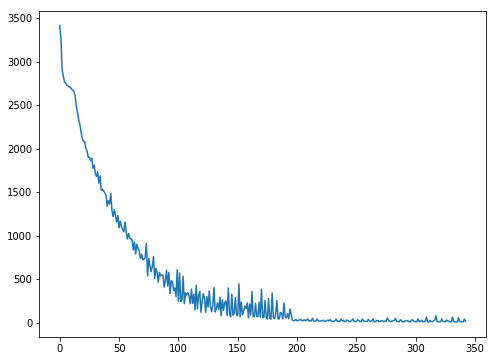

In [10]:
df = pd.DataFrame(history.history)
display(df.describe(percentiles=[0.25 * i for i in range(4)] + [0.95, 0.99]))
df['loss'].plot(figsize=(8, 6))

In [11]:
x_eval_out = []
for i in range(len(X_train_out)):
    x_eval_out.append(X_train_out[i])

lossvals = model.evaluate(X_train, x_eval_out)
#print(model.metrics_names)
print(lossvals)

16/16 [==============================] - 12s
[10.650057792663574, 2.3114938735961914, 0.4364374876022339, 0.005619588773697615, 0.3285669684410095, 0.010230107232928276, 0.006608658470213413, 0.02784121409058571, 0.0007918010232970119, 0.0013188887387514114, 0.0012436792021617293, 0.00025852047838270664, 0.000213590421481058, 0.0013650583568960428, 0.0004595888894982636, 0.00014441671373788267, 0.0006385372835211456, 0.00032144528813660145, 7.796731370035559e-05, 0.0026846597902476788, 0.001282506505958736, 6.81588426232338e-05, 0.0002962315920740366, 0.0005338992923498154, 8.727953536435962e-05, 0.0018906830810010433, 0.0014370984863489866, 6.992576527409256e-05, 0.008035209961235523, 0.02735328860580921, 0.00018794828793033957, 0.0009410775965079665, 0.004661659710109234, 0.00013482896611094475, 0.05500171333551407, 0.0003175018064212054, 7.780012674629688e-05, 0.0009066920028999448, 0.0005603592144325376, 0.000917681201826781, 0.0016646718140691519, 0.00029614067170768976, 7.7557910

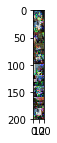

Elapsed:  1280.993500471115


In [12]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    out = e_x / e_x.sum()
    return out

def gen_image(model, num_samples=batch_size):
    x_sample = np.zeros((num_samples, img_rows, img_cols, img_chns))
    
    # Iteratively generate each conditional pixel P(x_i | x_{1,..,i-1})
    for i in range(img_rows):
        for j in range(img_cols):
            for k in range(img_chns):
                x_out = model.predict(x_sample, num_samples)
                index = i * img_cols * img_chns + j * img_chns + k
                for n in range(num_samples):
                    pvals = softmax(x_out[index][n])
                    pvals /= (np.sum(pvals) + 1e-5)
                    pixel_val = np.argmax(np.random.multinomial(1, pvals))
                    x_sample[n, i, j, k] = pixel_val * pixel_level_divisor / 255.
                    #print("====", i, j, k, pixel_val, x_sample[n, i, j, k])
                    #print("    ", x_out[index][n])
                    #print("    ", pvals)
                    #print("    ", draw)
                    #print(pixel_val, x_sample[n, i, j, k])
                    #break
        #print("row", i)
        #if i >= 1:
        #    break
                
    return x_sample


start = time.time()

n = 10
figure = np.zeros((img_rows * n, img_cols * batch_size, img_chns))
for i in range(n):
    samples = gen_image(model)
    for j in range(batch_size):
        img = samples[j] 
        # print(img)
        d_x = i * img_rows
        d_y = j * img_cols
        figure[d_x:d_x + img_rows, d_y:d_y + img_cols] = img
        
plt.figure(figsize=(2*n, 2*batch_size))
plt.imshow(figure)
plt.show()

done = time.time()
elapsed = done - start
print("Elapsed: ", elapsed)

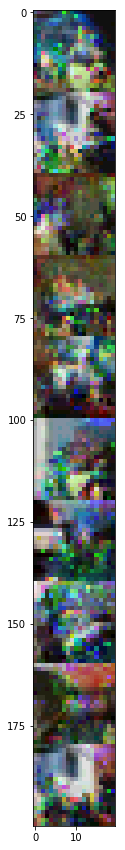

In [13]:
plt.figure(figsize=(15, 15))
plt.imshow(figure)
plt.show()


In [14]:
#if os.environ.get('OUTDIR', None):
#    encoder.save(os.path.join(os.environ['OUTDIR'], 'encoder-depth-' + str(resnet_depth) + '.h5'))
#    decoder.save(os.path.join(os.environ['OUTDIR'], 'decoder-depth-' + str(resnet_depth) + '.h5'))
#
#    vals = {k: v for k, v in locals().items() if type(v) in [int, float, bool]}
#    with open(os.path.join(os.environ['OUTDIR'], 'params-depth-' + str(resnet_depth) + '.json'), 'w') as f:
#        json.dump(vals, f)

In [15]:
#data = np.ones([3, 3, 6, 1])
#
#data.shape
#ptype = 'ba'
#mid = data.shape[0] // 2
#if ptype[0] == 'r':
#    filt_prev = 0
#    filt_thres = int(data.shape[2] / 3)
#elif ptype[0] == 'g':
#    filt_prev = int(data.shape[2] / 3)
#    filt_thres = int(2 * data.shape[2] / 3)
#else:
#    filt_prev = int(2 * data.shape[2] / 3)
#    filt_thres = data.shape[2]
#    
#print(data.shape, ptype, mid, filt_prev, filt_thres)
#
#for k1 in range(data.shape[0]):
#    for k2 in range(data.shape[1]):
#        for chan in range(data.shape[2]):
#            for filt in range(data.shape[3]):
#                if ptype[1] == 'a' and chan >= filt_prev:
#                    if k1 > mid or (k1 >= mid and k2 >= mid) or chan >= filt_thres:
#                        data[k1, k2, chan, filt] = 0
#                else:
#                    if k1 > mid or (k1 >= mid and k2 > mid) or chan >= filt_thres:
#                        data[k1, k2, chan, filt] = 0
#    
#print(data[:, :, 0, 0])
#print(data[:, :, filt_thres-1, 0])
#data

# Notes

* Did the last conv layer wrong (did a masking layer, when I should have done a 1x1 on each channel)
* Debug using single image, then grow it
* GPU small, so cut down problem to 20x20x3; discretize outputs to 16 levels for each channel (vs. 256)
* Found the tensorflow loss function the best, didn't have to duplicate softmax, then call keras, which then converts back to a probability
